![JohnSnowLabs](https://sparknlp.org/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp/blob/master/examples/python/transformers/openvino/HuggingFace_OpenVINO_in_Spark_NLP_Janus.ipynb)

# Import OpenVINO Janus models from HuggingFace 🤗 into Spark NLP 🚀

This notebook provides a detailed walkthrough on optimizing and importing Janus models from HuggingFace  for use in Spark NLP, with [Intel OpenVINO toolkit](https://www.intel.com/content/www/us/en/developer/tools/openvino-toolkit/overview.html). The focus is on converting the model to the OpenVINO format and applying precision optimizations (INT8 and INT4), to enhance the performance and efficiency on CPU platforms using [Optimum Intel](https://huggingface.co/docs/optimum/main/en/intel/inference).

Let's keep in mind a few things before we start 😊

- OpenVINO support was introduced in  `Spark NLP 5.4.0`, enabling high performance CPU inference for models. So please make sure you have upgraded to the latest Spark NLP release.
- Model quantization is a computationally expensive process, so it is recommended to use a runtime with more than 32GB memory for exporting the quantized model from HuggingFace.
- You can import Janus models via `Janus`. These models are usually under `Text Generation` category and have `Janus` in their labels.
- Reference: [Janus](https://huggingface.co/docs/transformers/model_doc/llama#transformers.Janus)
- Some [example models](https://huggingface.co/models?search=Janus)

## 1. Export and Save the HuggingFace model

- Let's install `transformers` and `openvino` packages with other dependencies. You don't need `openvino` to be installed for Spark NLP, however, we need it to load and save models from HuggingFace.
- We lock `transformers` on version `4.41.2`. This doesn't mean it won't work with the future release, but we wanted you to know which versions have been tested successfully.

In [1]:
from pathlib import Path
import requests

In [ ]:

%pip install -q --upgrade transformers==4.41.2
%pip install -U --pre "openvino>2024.5" --extra-index-url https://storage.openvinotoolkit.org/simple/wheels/nightly
%pip install -q "git+https://github.com/eaidova/optimum-intel.git@ea/minicpmv"
%pip install -q  "nncf>=2.14.0"  "sentencepiece" "tokenizers>=0.12.1" "transformers>=4.45.0" "gradio>=4.36"
%pip install -q -U --pre --extra-index-url https://storage.openvinotoolkit.org/simple/wheels/nightly openvino-tokenizers openvino openvino-genai
%pip install -q --upgrade huggingface_hub
%pip install -q --upgrade onnx==1.15.0
%pip install -q --upgrade torch==2.3.0
%pip install -q "git+https://github.com/deepseek-ai/Janus" --extra-index-url https://download.pytorch.org/whl/cpu


import platform

if platform.system() == "Darwin":
    %pip install -q "numpy<2.0.0"

In [2]:

from pathlib import Path
import requests

utility_files = ["notebook_utils.py"]
local_helpers = ["ov_janus_helper.py", "gradio_helper.py"]

base_utils_url = "https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/"
base_local_files_url = "https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/janus-multimodal-generation/"


for util_path in utility_files:
    if not Path(util_path).exists():
        r = requests.get(base_utils_url + util_path)
        with open(util_path, "w") as f:
            f.write(r.text)

for util_path in local_helpers:
    if not Path(util_path).exists():
        r = requests.get(base_local_files_url + util_path)
        with open(util_path, "w") as f:
            f.write(r.text)

### 1.1 Convert the model to OpenVino

In [3]:
import nncf
from ov_janus_helper import convert_janus_model

model_id = "deepseek-ai/Janus-1.3B"
model_path = Path(model_id.split("/")[-1] + "-ov")

compression_configuration = {
    "mode": nncf.CompressWeightsMode.INT4_ASYM,
    "group_size": 64,
    "ratio": 1.0,
}

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


/home/prabod/anaconda3/envs/pth23/lib/python3.9/importlib/util.py:245: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  self.__spec__.loader.exec_module(self)
/home/prabod/anaconda3/envs/pth23/lib/python3.9/site-packages/transformers/models/auto/image_processing_auto.py:524: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
/home/prabod/anaconda3/envs/pth23/lib/python3.9/site-packages/attrdict/mapping.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
/home/prabod/anaconda3/envs/pth23/lib/python3.9/site-packages/attrdict/mixins.py:5: DeprecationWarning: Using or importing the ABCs from

In [4]:
convert_janus_model(model_id, model_path, compression_configuration)

✅ Janus-1.3B model already converted. You can find results in Janus-1.3B-ov


### 1.2 Load openvino models

In [5]:
import openvino as ov
core = ov.Core()

In [6]:
from pathlib import Path
from PIL import Image
from io import BytesIO
from janus.utils.io import load_pil_images
from janus.models import VLChatProcessor
import requests

input_prompt = "Describe image in details"

image_path = Path("cat_in_box.png")
processor = VLChatProcessor.from_pretrained(model_path)

if not image_path.exists():
    response = requests.get("https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/d5fbbd1a-d484-415c-88cb-9986625b7b11")
    image = Image.open(BytesIO(response.content)).convert("RGB")
    image.save(image_path)

conversation = [
    {
        "role": "User",
        "content": f"<image_placeholder>{input_prompt}\n",
        "images": [str(image_path)],
    },
    {"role": "Assistant", "content": ""},
]
pil_images = load_pil_images(conversation)

prepare_inputs = processor(conversations=conversation, images=pil_images, force_batchify=True)


Some kwargs in processor config are unused and will not have any effect: ignore_id, image_start_tag, image_end_tag, num_image_tokens, add_special_token, mask_prompt, image_tag, sft_format. 


In [7]:
model_dir = model_path
VISION_EMBEDDINGS = "openvino_vision_embeddings_model.xml"
TEXT_EMBEDDINGS = "openvino_text_embeddings_model.xml"
LANGUAGE_MODEL = "openvino_language_model.xml"
LM_HEAD = "openvino_lm_head_model.xml"
MERGE_MULTIMODAL = "openvino_multimodal_merge_model.xml"
GEN_HEAD = "openvino_gen_head_model.xml"
GEN_EMBEDDINGS = "openvino_gen_embeddings_model.xml"
GEN_DECODER = "openvino_gen_decoder_model.xml"

In [8]:
text_embeddings =  core.compile_model(model_dir / TEXT_EMBEDDINGS, "CPU")
vision_embeddings = core.compile_model(model_dir / VISION_EMBEDDINGS, "CPU")
language_model = core.compile_model(model_dir / LANGUAGE_MODEL, "CPU")
lm_head = core.compile_model(model_dir / LM_HEAD, "CPU")
request = language_model.create_infer_request()

In [9]:
import torch

class MergeMultiModalInputs(torch.nn.Module):
    def __init__(self,image_token_index=100594):
        super().__init__()
        self.image_token_index = image_token_index

    def forward(
        self,
        vision_embeds,
        inputs_embeds,
        input_ids,
    ):
        image_features = vision_embeds
        inputs_embeds = inputs_embeds
        special_image_mask = (input_ids == self.image_token_index).unsqueeze(-1).expand_as(inputs_embeds)
        # image_features = image_features.to(inputs_embeds.dtype)
        final_embedding = inputs_embeds.masked_scatter(special_image_mask, image_features)

        return {
            "final_embeddings": final_embedding
        }

In [10]:
# sample text and image embeddings

inputs = {}
# Set the initial input_ids
current_input_ids = prepare_inputs["input_ids"]
attention_mask = prepare_inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
position_ids.masked_fill_(attention_mask == 0, 1)
pixel_values = prepare_inputs["pixel_values"]

# Set the initial input_ids
text_out = text_embeddings(prepare_inputs["input_ids"])[0]
vision_out = vision_embeddings(pixel_values)[0]

In [11]:
import openvino as ov

torch_model_merge = MergeMultiModalInputs()

# convert MergeMultiModalInputs to OpenVINO IR
ov_model_merge = ov.convert_model(
    torch_model_merge,
    example_input={
        "vision_embeds": vision_out,
        "inputs_embeds": text_out,
        "input_ids": current_input_ids,
    }
)
ov.save_model(ov_model_merge, model_path/"openvino_multimodal_merge_model.xml")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
# check if all the models are converted

print("⌛ Check if all models are converted")
lang_model_path = model_dir / "openvino_language_model.xml"
image_embed_path = model_dir / "openvino_vision_embeddings_model.xml"
img_projection_path = model_dir / "openvino_text_embeddings_model.xml"
merge_model_path = model_dir / "openvino_multimodal_merge_model.xml"
gen_head_path = model_dir / "openvino_gen_head_model.xml"
gen_embed_path = model_dir / "openvino_gen_embeddings_model.xml"
gen_decoder_path = model_dir / "openvino_gen_decoder_model.xml"






if all(
    [
        lang_model_path.exists(),
        image_embed_path.exists(),
        img_projection_path.exists(),
        merge_model_path.exists(),
        gen_head_path.exists(),
        gen_embed_path.exists(),
        gen_decoder_path.exists(),
    ]
):
    print(f"✅ All models are converted. You can find results in {model_dir}")
else:
    print("❌ Not all models are converted. Please check the conversion process")

⌛ Check if all models are converted
✅ All models are converted. You can find results in Janus-1.3B-ov


### 1.2 Copy assets to the assets folder

In [13]:
# update the preprocessor_config.json with the format needed for spark-nlp
import json

with open(model_path / "preprocessor_config.json") as f:
    preprocessor_config = json.load(f)

preprocessor_config["size"] = {
    "width": preprocessor_config["image_size"],
    "height": preprocessor_config["image_size"],
}

preprocessor_config["do_normalize"] = True
preprocessor_config["do_resize"] = True
preprocessor_config["do_rescale"] = True
preprocessor_config["resample"] = 2

with open(model_path / "preprocessor_config.json", "w") as f:
    json.dump(preprocessor_config, f)



In [14]:
assets_dir = model_dir / "assets"
assets_dir.mkdir(exist_ok=True)

# copy all the assets to the assets directory (json files, vocab files, etc.)

import shutil

# copy all json files

for file in model_dir.glob("*.json"):
    shutil.copy(file, assets_dir)

    


In [15]:
!ls -lh {model_dir}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


total 2.2G
drwxrwxr-x 2 prabod prabod 4.0K Feb  5 07:59 assets
-rw-rw-r-- 1 prabod prabod 1.5K Jan 22 05:52 config.json
-rw-rw-r-- 1 prabod prabod  82M Jan 22 05:54 openvino_gen_decoder_model.bin
-rw-rw-r-- 1 prabod prabod 370K Jan 22 05:54 openvino_gen_decoder_model.xml
-rw-rw-r-- 1 prabod prabod 8.3M Jan 22 05:54 openvino_gen_embeddings_model.bin
-rw-rw-r-- 1 prabod prabod 8.8K Jan 22 05:54 openvino_gen_embeddings_model.xml
-rw-rw-r-- 1 prabod prabod  73M Jan 22 05:54 openvino_gen_head_model.bin
-rw-rw-r-- 1 prabod prabod 6.7K Jan 22 05:54 openvino_gen_head_model.xml
-rw-rw-r-- 1 prabod prabod 640M Jan 22 05:54 openvino_language_model.bin
-rw-rw-r-- 1 prabod prabod 2.1M Jan 22 05:54 openvino_language_model.xml
-rw-rw-r-- 1 prabod prabod 400M Jan 22 05:52 openvino_lm_head_model.bin
-rw-rw-r-- 1 prabod prabod 2.2K Jan 22 05:52 openvino_lm_head_model.xml
-rw-rw-r-- 1 prabod prabod   40 Feb 10 05:00 openvino_multimodal_merge_model.bin
-rw-rw-r-- 1 prabod prabod 9.8K Feb 10 05:00 openvino

In [16]:
!ls -lh {assets_dir}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


total 7.4M
-rw-rw-r-- 1 prabod prabod 1.5K Feb 10 05:00 config.json
-rw-rw-r-- 1 prabod prabod  370 Feb 10 05:00 preprocessor_config.json
-rw-rw-r-- 1 prabod prabod  288 Feb 10 05:00 processor_config.json
-rw-rw-r-- 1 prabod prabod  663 Feb 10 05:00 special_tokens_map.json
-rw-rw-r-- 1 prabod prabod 104K Feb 10 05:00 tokenizer_config.json
-rw-rw-r-- 1 prabod prabod 7.3M Feb 10 05:00 tokenizer.json


### 1.3 Test the openvino model

In [17]:
import openvino as ov
import torch

core = ov.Core()
device = "CPU"


In [18]:
text_embeddings =  core.compile_model(model_dir / TEXT_EMBEDDINGS, "CPU")
vision_embeddings = core.compile_model(model_dir / VISION_EMBEDDINGS, "CPU")
language_model = core.compile_model(model_dir / LANGUAGE_MODEL, "CPU")
lm_head = core.compile_model(model_dir / LM_HEAD, "CPU")
model_merge = core.compile_model(model_dir / MERGE_MULTIMODAL, "CPU")
request = language_model.create_infer_request()

In [19]:
generated_tokens = []

from pathlib import Path
from PIL import Image
from io import BytesIO
from janus.utils.io import load_pil_images
import requests
import numpy as np

input_prompt = "Describe image in details"

image_path = Path("cat_in_box.png")

if not image_path.exists():
    response = requests.get("https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/d5fbbd1a-d484-415c-88cb-9986625b7b11")
    image = Image.open(BytesIO(response.content)).convert("RGB")
    image.save(image_path)

conversation = [
    {
        "role": "User",
        "content": f"<image_placeholder>{input_prompt}\n",
        "images": [str(image_path)],
    },
    {"role": "Assistant", "content": ""},
]
pil_images = load_pil_images(conversation)

prepare_inputs = processor(conversations=conversation, images=pil_images, force_batchify=True)
request = language_model.create_infer_request()
merge_model_request = model_merge.create_infer_request()

current_input_ids = prepare_inputs["input_ids"]
attention_mask = prepare_inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
position_ids.masked_fill_(attention_mask == 0, 1)

pixel_values = prepare_inputs["pixel_values"]

for i in range(50):
    # Generate input embeds each time
    if current_input_ids.shape[-1] > 1:
        vision_embeds = vision_embeddings(pixel_values)[0]    
    text_embeds = text_embeddings(current_input_ids)[0]

    
    if i == 0:
        # Merge the text and vision embeddings
        text_embeds = torch.from_numpy(text_embeds)
        vision_embeds = torch.from_numpy(vision_embeds)
        final_embedding = model_merge({
            "vision_embeds": vision_embeds,
            "inputs_embeds": text_embeds,
            "input_ids": current_input_ids,
        }, share_inputs=True)[0]
        input_embeds = final_embedding
    else:
        input_embeds = torch.from_numpy(text_embeds)
    inputs = {}
    # Prepare inputs for the model
    inputs["inputs_embeds"] = input_embeds
    inputs["attention_mask"] = attention_mask
    inputs["position_ids"] = position_ids
    inputs["beam_idx"] = np.arange(attention_mask.shape[0], dtype=int)

    request.start_async(inputs,share_inputs=True)
    request.wait()
    hidden_states = request.get_tensor("last_hidden_state").data
    logits = torch.from_numpy(lm_head(hidden_states,share_inputs=True,share_outputs=True)[0])
    
    next_token =logits.argmax(-1)[0][-1]

    # Append the generated token
    generated_tokens.append(next_token)
    
    # Update input_ids with the new token
    current_input_ids = torch.cat([next_token.unsqueeze(0).unsqueeze(0)], dim=-1)
    
    # update the attention mask
    attention_mask = torch.cat([attention_mask, torch.ones_like(attention_mask[:, :1])], dim=-1)

    # Update inputs for the next iteration
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)
    position_ids = position_ids[:, -current_input_ids.shape[1] :]
    inputs["position_ids"] = position_ids

In [20]:
generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

print("Question:\n Describe image in details")
print("Answer:")
print(generated_text)

Question:
 Describe image in details
Answer:
The image depicts a gray and white tabby cat lying comfortably inside a cardboard box. The cat is lying on its back with its paws up in the air, and its eyes are closed, suggesting it is relaxed and possibly asleep. The box is placed


## 2. Import and Save Janus in Spark NLP

- Let's install and setup Spark NLP in Google Colab
- This part is pretty easy via our simple script

In [ ]:
! wget -q http://setup.johnsnowlabs.com/colab.sh -O - | bash

Let's start Spark with Spark NLP included via our simple `start()` function

In [1]:
import sparknlp

# let's start Spark with Spark NLP
spark = sparknlp.start()


24/11/07 09:56:55 WARN Utils: Your hostname, minotaur resolves to a loopback address: 127.0.1.1; using 192.168.1.4 instead (on interface eno1)
24/11/07 09:56:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/11/07 09:56:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [ ]:
imageClassifier = JanusForMultiModal.loadSavedModel(model_dir, spark) \
            .setInputCols("image_assembler") \
            .setOutputCol("answer")

25/03/11 02:20:47 WARN NativeLibrary: Failed to load library null: java.lang.UnsatisfiedLinkError: Can't load library: /tmp/openvino-native2264403399992055719/libtbb.so.2


In [3]:
imageClassifier.write().overwrite().save("file:///tmp/Janus_spark_nlp")

In [4]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql.functions import lit
from pyspark.ml import Pipeline
from pathlib import Path
import os

# download two images to test into ./images folder

url1 = "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/d5fbbd1a-d484-415c-88cb-9986625b7b11"
url2 = "http://images.cocodataset.org/val2017/000000039769.jpg"

Path("images").mkdir(exist_ok=True)

!wget -q -O images/image1.jpg {url1}
!wget -q -O images/image2.jpg {url2}



images_path = "file://" + os.getcwd() + "/images/"
image_df = spark.read.format("image").load(
    path=images_path
)

test_df = image_df.withColumn("text", lit("You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.\n\nUser: <image_placeholder>Describe image in details\n\nAssistant:"))

image_assembler = ImageAssembler().setInputCol("image").setOutputCol("image_assembler")

imageClassifier = JanusForMultiModal.load("file:///tmp/Janus_spark_nlp")\
            .setMaxOutputLength(50) \
            .setInputCols("image_assembler") \
            .setOutputCol("answer")

pipeline = Pipeline(
            stages=[
                image_assembler,
                imageClassifier,
            ]
        )

model = pipeline.fit(test_df)

In [5]:
light_pipeline = LightPipeline(model)
image_path = "file://" + os.getcwd() + "/images/" + "image1.jpg"
print("image_path: " + image_path)
annotations_result = light_pipeline.fullAnnotateImage(
    image_path,
    "You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.\n\nUser: <image_placeholder>Describe image in details\n\nAssistant:"
)

for result in annotations_result:
    print(result["answer"])

image_path: file:///home/prabod/Projects/spark-nlp/examples/python/transformers/openvino/images/image1.jpg
[Annotation(document, 0, 222, The image depicts a gray tabby cat lounging in a cardboard box. The cat is lying on its back with its legs and paws spread out in a relaxed manner. Its eyes are closed, and it appears to be enjoying a moment of tranquility., Map(), [])]


## Image Generation with Janus



To use Janus for image generation, an image must be provided to the pipeline as it is a required column for the ImageAssembler. This image can be an empty image or any placeholder image. The provided image will not be used to generate a new image but will serve as a necessary input for the pipeline.

image_path: file:///tmp/empty_image.jpg


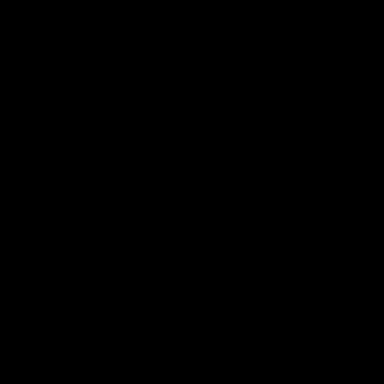

In [2]:
# create an empty image to test the model

from PIL import Image
import numpy as np

image = Image.new("RGB", (384, 384))
image.save("/tmp/empty_image.jpg")

image_path = "file:///tmp/empty_image.jpg"
print("image_path: " + image_path)

image

In [4]:

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql.functions import lit
from pyspark.ml import Pipeline
from pathlib import Path
import os

image_df = spark.read.format("image").load(
    path=image_path
)
test_df = image_df.withColumn("text", lit("User: Create a detailed image of a whimsical forest filled with vibrant, oversized mushrooms, glowing flowers, and towering, twisted trees with bioluminescent vines. The atmosphere is magical, with soft, ethereal light filtering through a misty canopy. Small floating orbs of light hover among the branches, and tiny fairy-like creatures flit through the air. A winding, moss-covered path leads to a mysterious glowing portal hidden within the trees. The scene should feel enchanting, otherworldly, and full of wonder, like a dreamlike fantasy realm.\n\nAssistant:"))


image_assembler = ImageAssembler().setInputCol("image").setOutputCol("image_assembler")

imageClassifier = JanusForMultiModal.load("file:///tmp/Janus_spark_nlp")\
            .setMaxOutputLength(50) \
            .setImageGenerateMode(True) \
            .setInputCols("image_assembler") \
            .setOutputCol("answer")

generate_pipeline = Pipeline(
            stages=[
                image_assembler,
                imageClassifier,
            ]
        )

generate_model = generate_pipeline.fit(test_df)
generation_result = generate_model.transform(test_df)

In [5]:
metadata = generation_result.select("answer.metadata").collect()


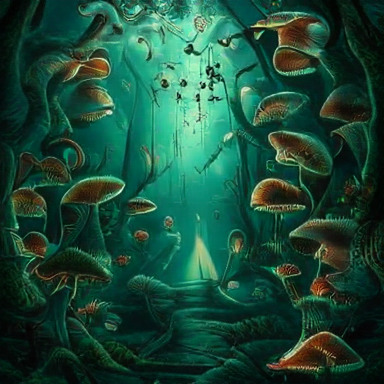

In [6]:
import io
from PIL import Image
import base64
from IPython.display import display

for row in metadata:
    result = row["metadata"][0]
    for key in result:
        if "generated_image" in key:
            image = result[key]
            image = base64.b64decode(image)
            image = Image.open(io.BytesIO(image)).resize((384, 384))
            display(image)